![logo](https://i.imgur.com/nvJusr5.png)

# Casual Impact - Theoretical Model

In [1]:
# DataWrangling and Numerical Packages
import pandas as pd
import numpy as np

In [2]:
# DataVisualization
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from causalimpact import CausalImpact

## Building Casual Impact Model - 2

In [4]:
# timeIndex
ti = pd.date_range(start='2020-01-01', end='2020-07-31')

In [5]:
# Let's Create a Linear Function that determinates the relationship between or y and X variables
def response_linearfunc(x, a, b):
    return a*x + b

In [6]:
# Predictor Variable X - We're going to Use a random variable, normally distributed
xdata = np.random.randn(len(ti)) + 5

# Response Variable y - Linear Combination of X + random noise
y_raw = response_linearfunc(xdata, 2, 1)
y_noise = (0.1 * np.random.normal(size=xdata.size) * y_raw)
ydata = y_raw + y_noise

In [7]:
### Building a DataFrame
df = pd.DataFrame(data={'y': ydata, 
                        'X': xdata}, 
                  index=ti)

In [8]:
# Header of the Result DataFrame
df.head()

,y,X
2020-01-01,8.527863,4.076944
2020-01-02,12.958439,5.609674
2020-01-03,8.655206,4.475239
2020-01-04,12.151319,4.843366
2020-01-05,8.360193,3.272133


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 213 entries, 2020-01-01 to 2020-07-31
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       213 non-null    float64
 1   X       213 non-null    float64
dtypes: float64(2)
memory usage: 5.0 KB


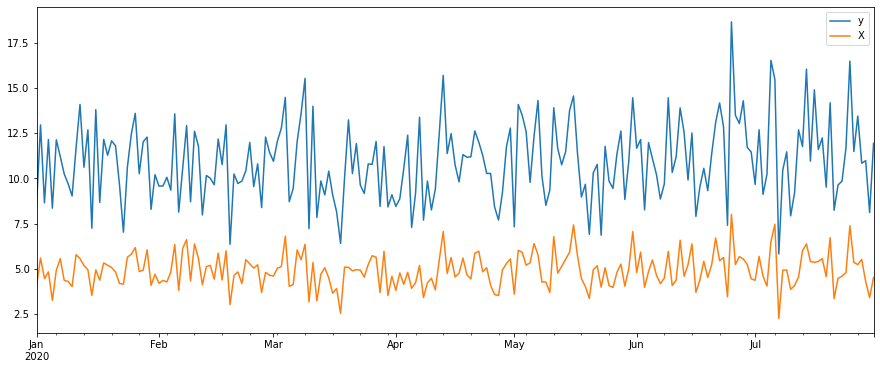

In [10]:
# Plotting the Series
df.plot(figsize=(15,6));

### Adding Linear Trend to y

In [11]:
# Creating Linear Trend
linear_trend = response_linearfunc(np.linspace(0,5,len(ti)), 3, 1)

In [12]:
df['linearTrend'] = linear_trend

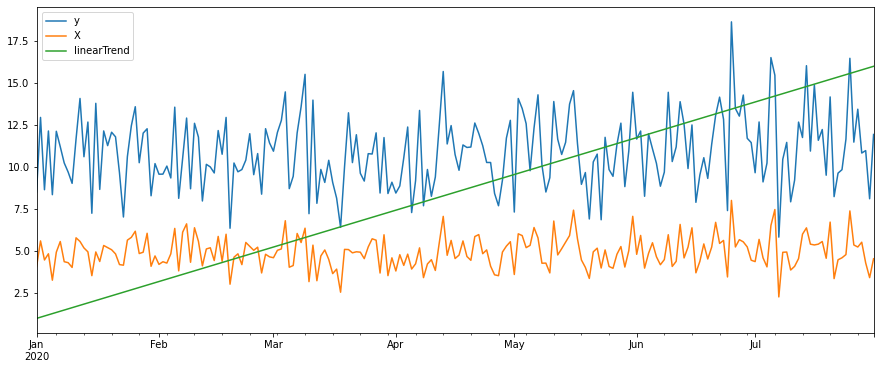

In [13]:
# Re-Plotting the Series
df.plot(figsize=(15,6));

In [14]:
df['y'] = df['y'] + df['linearTrend']

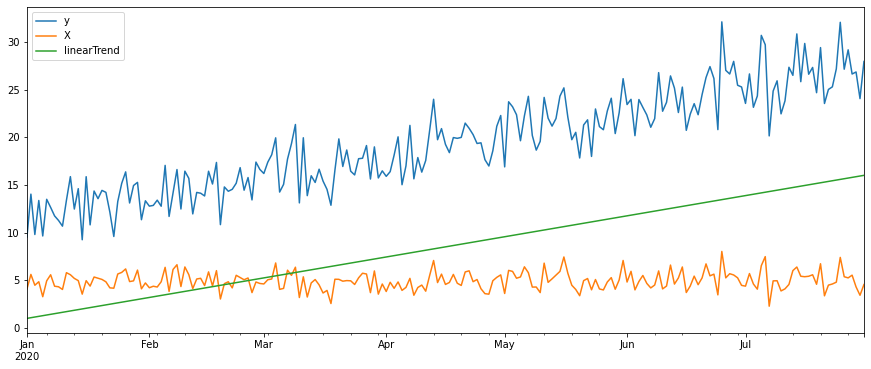

In [15]:
# Re-Plotting the Series
df.plot(figsize=(15,6));

### Adding Seasonal Trend

In [16]:
# Syntethic Seasonal Data
def simulate_seasonal_term(periodicity, total_cycles, noise_std=1.,
                           harmonics=None):
    duration = periodicity * total_cycles
    assert duration == int(duration)
    duration = int(duration)
    harmonics = harmonics if harmonics else int(np.floor(periodicity / 2))

    lambda_p = 2 * np.pi / float(periodicity)

    gamma_jt = noise_std * np.random.randn((harmonics))
    gamma_star_jt = noise_std * np.random.randn((harmonics))

    total_timesteps = 100 * duration # Pad for burn in
    series = np.zeros(total_timesteps)
    for t in range(total_timesteps):
        gamma_jtp1 = np.zeros_like(gamma_jt)
        gamma_star_jtp1 = np.zeros_like(gamma_star_jt)
        for j in range(1, harmonics + 1):
            cos_j = np.cos(lambda_p * j)
            sin_j = np.sin(lambda_p * j)
            gamma_jtp1[j - 1] = (gamma_jt[j - 1] * cos_j
                                 + gamma_star_jt[j - 1] * sin_j
                                 + noise_std * np.random.randn())
            gamma_star_jtp1[j - 1] = (- gamma_jt[j - 1] * sin_j
                                      + gamma_star_jt[j - 1] * cos_j
                                      + noise_std * np.random.randn())
        series[t] = np.sum(gamma_jtp1)
        gamma_jt = gamma_jtp1
        gamma_star_jt = gamma_star_jtp1
    wanted_series = series[-duration:] # Discard burn in

    return wanted_series

In [17]:
duration = len(ti)
periodicities = [30]
num_harmonics = [1]
std = np.array([0.1, 0.1])

In [18]:
terms = []
for ix, _ in enumerate(periodicities):
    s = simulate_seasonal_term(
        periodicities[ix],
        duration / periodicities[ix],
        harmonics=num_harmonics[ix],
        noise_std=std[ix])
    terms.append(s)
terms.append(np.ones_like(terms[0]) * 10.)
seasons = pd.Series(np.sum(terms, axis=0))

In [19]:
df['seasonalTrend'] = (seasons.values / 5) - 3

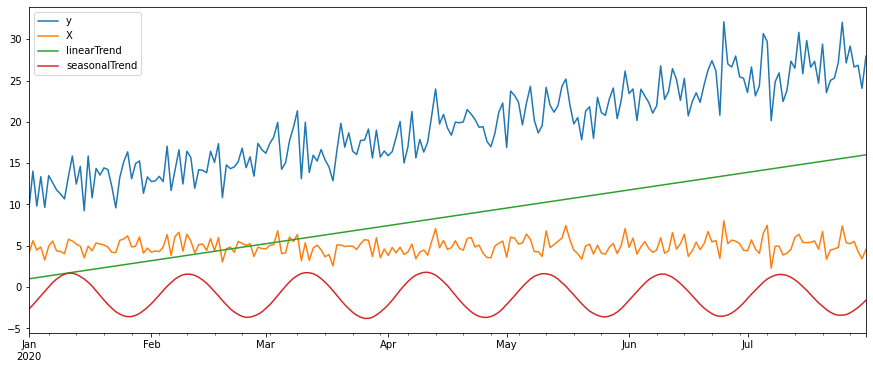

In [20]:
# Re-Plotting the Series
df.plot(figsize=(15,6));

In [21]:
df['y'] = df['y'] + df['seasonalTrend']

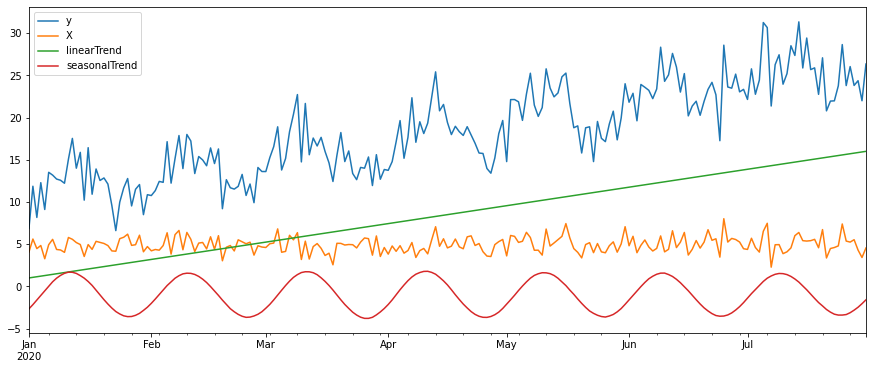

In [22]:
# Re-Plotting the Series
df.plot(figsize=(15,6));

In [23]:
# Introducing Incremental Effect at last 30 days by 5 units
df['y'].loc['2020-07-01':] = df['y'].loc['2020-07-01':] + 5

In [24]:
df.drop(['linearTrend', 'seasonalTrend'], axis=1, inplace=True)

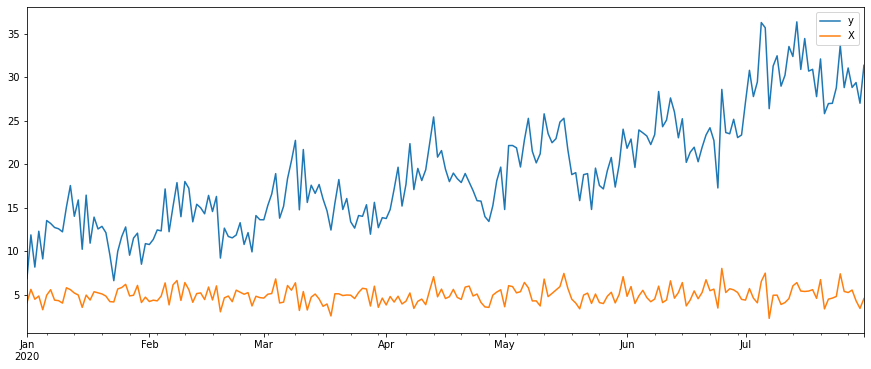

In [25]:
# Checking the Result of Incremental Effect
df.plot(figsize=(15,6));

### The Casual Impact Analysis

In [26]:
pre_period = ["2020-01-01","2020-06-30"]
post_period = ["2020-07-01","2020-07-31"]

In [27]:
ciModel = CausalImpact(df, pre_period, post_period)

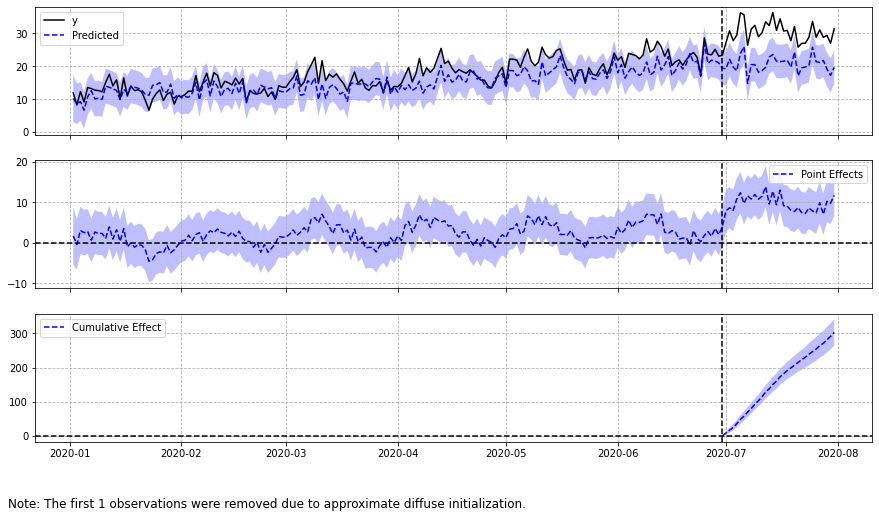

In [28]:
# Model Results Plot
ciModel.plot(figsize=(15,8));

In [29]:
# Model Results - Simple 
print(ciModel.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    30.44              943.79
Prediction (s.d.)         20.67 (0.64)       640.84 (19.74)
95% CI                    [19.44, 21.94]     [602.77, 680.16]

Absolute effect (s.d.)    9.77 (0.64)        302.95 (19.74)
95% CI                    [8.5, 11.0]        [263.63, 341.02]

Relative effect (s.d.)    47.27% (3.08%)     47.27% (3.08%)
95% CI                    [41.14%, 53.21%]   [41.14%, 53.21%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


### Passing Periodicity

In [30]:
ciModel = CausalImpact(df, pre_period, post_period, nseasons=[{'period': 30}])

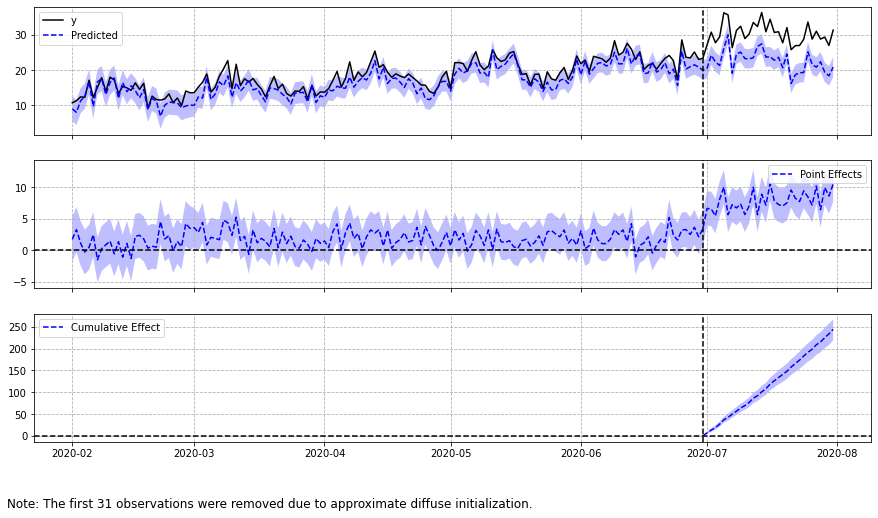

In [31]:
# Model Results Plot
ciModel.plot(figsize=(15,8));

In [32]:
# Model Results - Simple 
print(ciModel.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    30.44              943.79
Prediction (s.d.)         22.56 (0.4)        699.23 (12.31)
95% CI                    [21.82, 23.38]     [676.53, 724.78]

Absolute effect (s.d.)    7.89 (0.4)         244.57 (12.31)
95% CI                    [7.07, 8.62]       [219.02, 267.26]

Relative effect (s.d.)    34.98% (1.76%)     34.98% (1.76%)
95% CI                    [31.32%, 38.22%]   [31.32%, 38.22%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
